# Test and visualize best model


Best model out of the four models is custom3.
* load test dataset
* visualize test datset
* load model
* run model on the test batch
* visualize results

## Imports

In [14]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [15]:
import tensorflow_addons as tfa

In [2]:
dataset_dir = pathlib.Path("../phi_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

## Load dataset

In [3]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [4]:
trusted_list = os.listdir(dataset_dir/'trusted_list')
del trusted_list[trusted_list.index('targets.txt')]
trusted_number_images = [len(os.listdir(dataset_dir/f'trusted_list/{site}')) for site in trusted_list]

phishing_sites = os.listdir(dataset_dir/'phishing')
del phishing_sites[phishing_sites.index('targets2.txt')]
phishing_number_images = [len(os.listdir(dataset_dir/f'phishing/{site}')) for site in phishing_sites]


print(f"Number of domains in trusted list: {len(trusted_list)}, with {sum(trusted_number_images)} images")
print("The trusted list:")
print([(site, n) for site, n in zip(trusted_list, trusted_number_images)])
print(f"\n\nNumber of domains in phishing list: {len(phishing_sites)}, with {sum(phishing_number_images)} images")
print("The phishing list:")
print([(site, n) for site, n in zip(phishing_sites, phishing_number_images)])

print(f"\nDomains equal for both classes: {not sum([trusted_site not in phishing_sites for trusted_site in trusted_list])}")
print(f"Total number of images {sum(phishing_number_images)+sum(trusted_number_images)}")
print("Dataset from: Sahar Abdelnaby (Phd student in a Saarland University)")

Number of domains in trusted list: 155, with 9363 images
The trusted list:
[('absa', 70), ('adidas', 77), ('adobe', 78), ('airbnb', 84), ('alibaba', 148), ('aliexpress', 54), ('allegro', 45), ('amazon', 45), ('ameli_fr', 52), ('american_express', 73), ('anadolubank', 53), ('aol', 27), ('apple', 103), ('arnet_tech', 55), ('aruba', 56), ('att', 120), ('azul', 47), ('bahia', 69), ('banco_de_occidente', 44), ('banco_inter', 35), ('bankia', 69), ('barclaycard', 53), ('barclays', 73), ('bbt', 63), ('bcp', 58), ('bestchange', 33), ('blizzard', 96), ('bmo', 196), ('bnp_paribas', 84), ('bnz', 42), ('boa', 54), ('bradesco', 54), ('bt', 65), ('caixa_bank', 69), ('canada', 54), ('capital_one', 48), ('capitec', 37), ('cathay_bank', 22), ('cetelem', 36), ('chase', 99), ('cibc', 67), ('cloudconvert', 53), ('cloudns', 43), ('cogeco', 37), ('commonwealth_bank', 66), ('cox', 26), ('crate_and_barrel', 23), ('cryptobridge', 49), ('daum', 66), ('db', 90), ('dhl', 89), ('dkb', 41), ('docmagic', 54), ('dropb

### Params

In [5]:
model_name = "wpd2"
batch_size = 16
img_height = 256
img_width = 512 

rest_split_ratio = 0.2
test_split_ratio = 0.2

### init dataset objects and splits

In [34]:
train_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'trusted_list',
  label_mode = 'categorical',
  validation_split=rest_split_ratio,
  subset="training",
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9346 files belonging to 155 classes.
Using 7477 files for training.


In [35]:
rest_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'trusted_list',
  label_mode = 'categorical',
  validation_split=rest_split_ratio,
  subset="validation",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9346 files belonging to 155 classes.
Using 1869 files for validation.


In [36]:
class_names = train_trusted_ds.class_names
num_classes = len(class_names)

In [37]:
train_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'phishing',
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode = 'categorical',
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1195 files belonging to 155 classes.
Using 239 files for validation.


In [38]:
rest_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'phishing',
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode = 'categorical',
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1195 files belonging to 155 classes.
Using 239 files for validation.


In [39]:
train_ds = train_trusted_ds.concatenate(train_phi_ds)
rest_ds = rest_trusted_ds.concatenate(rest_phi_ds)

In [40]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

132


In [41]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

## Visualize data

[ 22  34 146 129  94  64 153  27 101 152 113  41  88  31 128  90]


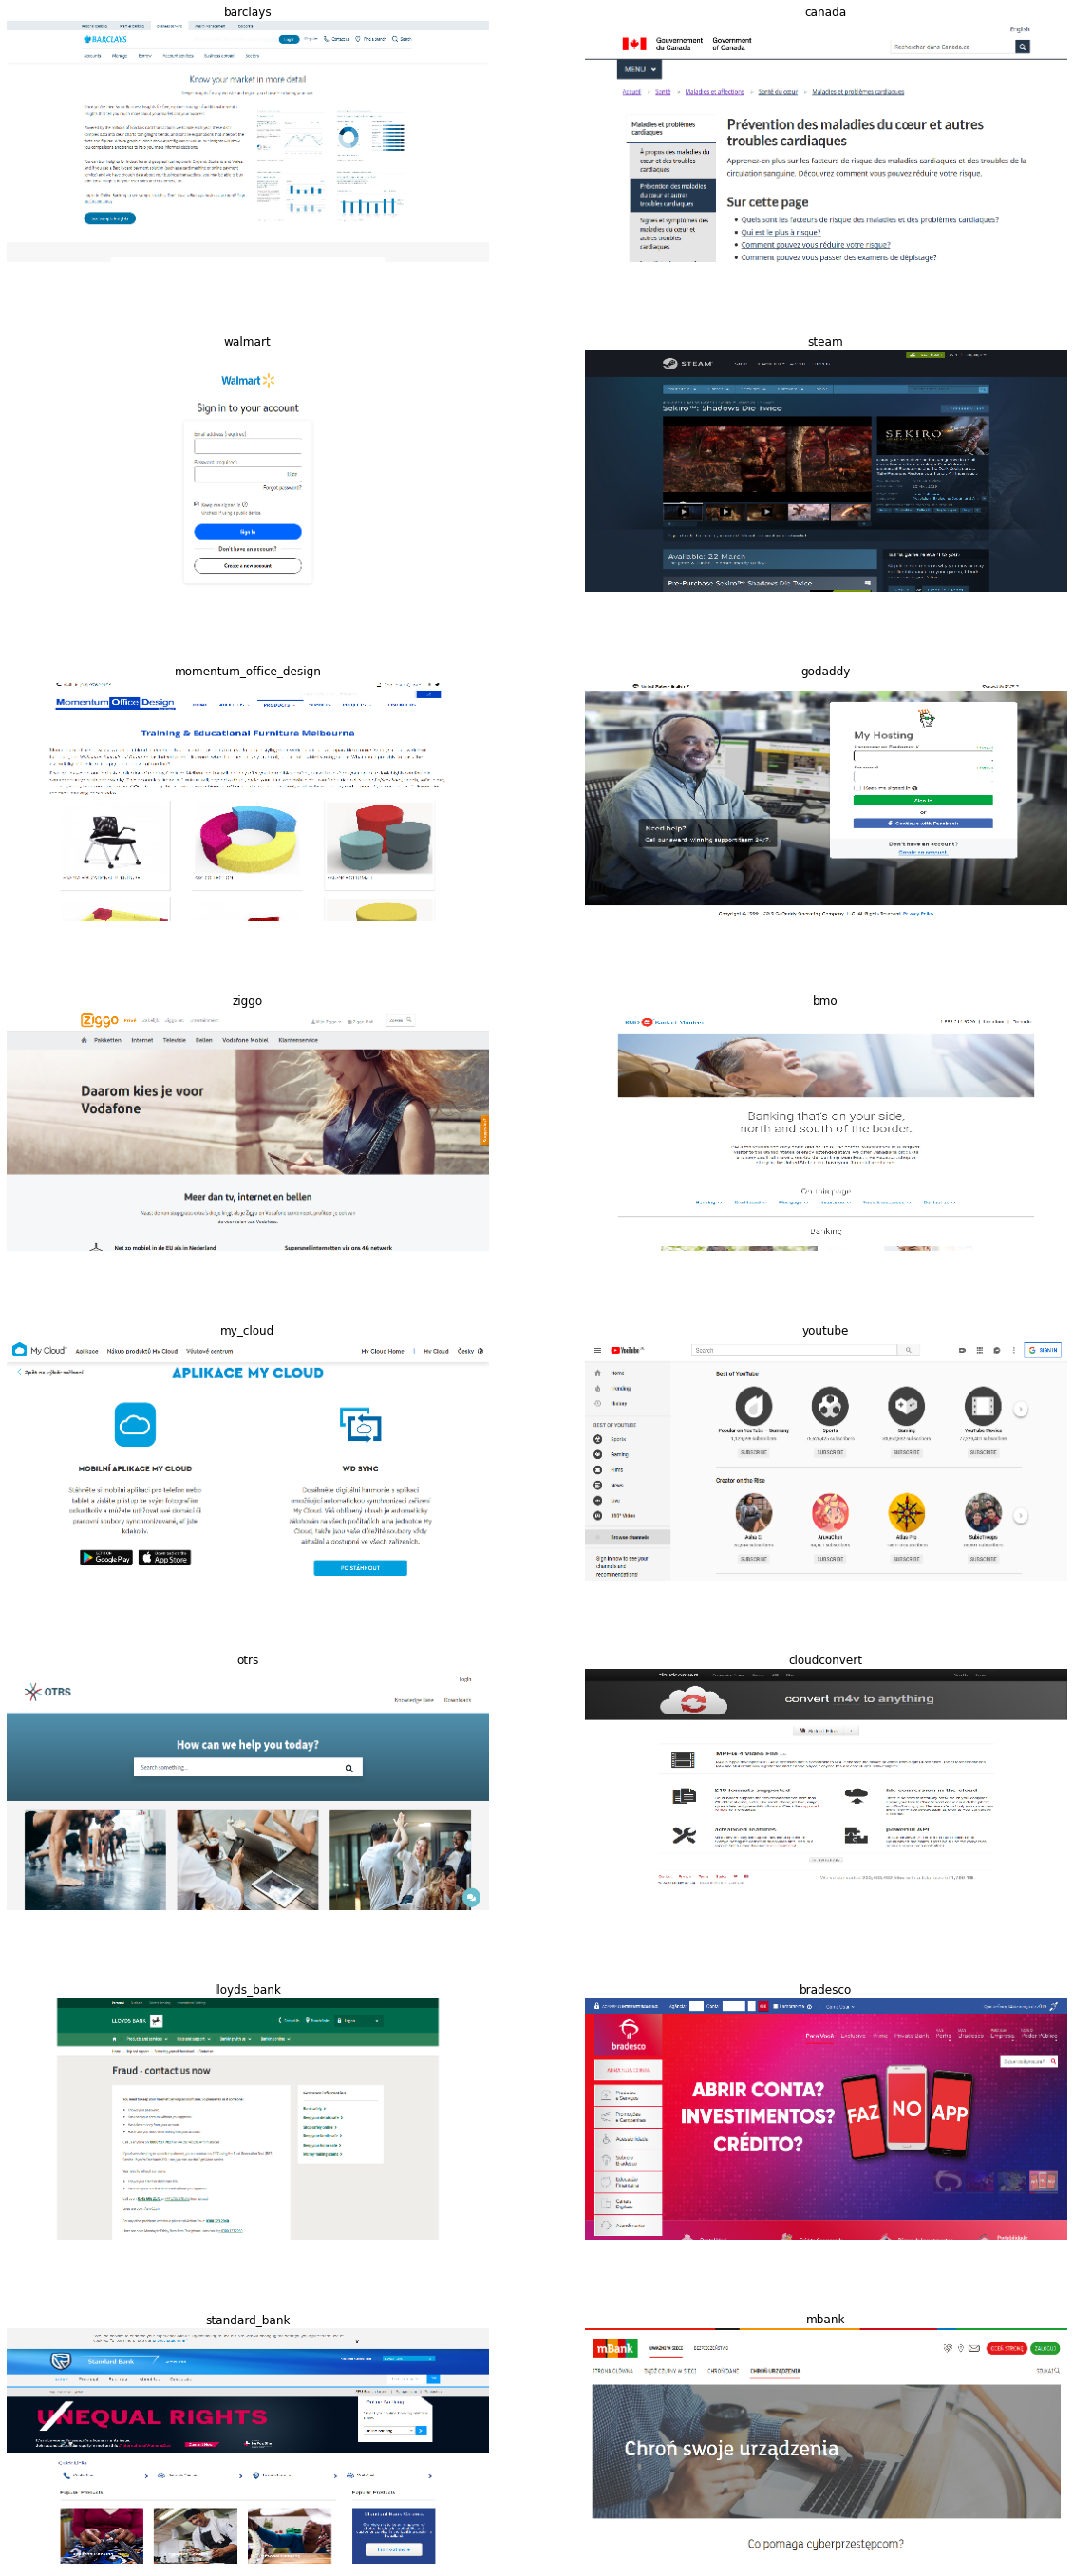

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
for images, labels in test_ds.take(1):
    imgs = images
    class_labels = labels.numpy().argmax(axis=-1)
    for i in range(16):
        ax = plt.subplot(8, 2, i + 1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(class_names[int(class_labels[i])])
        plt.axis("off")

## Load model (WPD2)

In [42]:
# change filename to the model you want to load
model_filename = "2021-12-11_18;40;33.772059_wpd2_valacc0.9462_e8_b16.tf"
model = keras.models.load_model(
    model_dir / model_filename,
#     compile=True
)

## Prepare metrics

In [53]:
class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.softmax(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class AUC(FromLogitsMixin, tf.metrics.AUC):
  ...

class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

In [83]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
    metrics=[
        'accuracy',
        Precision(from_logits=True),
        Recall(from_logits=True),
        F1Score(from_logits=True, num_classes=num_classes)
#         F1Score(from_logits=True, num_classes=num_classes, average='macro', threshold=0.5)
    ]
)

## Evaluate (test)

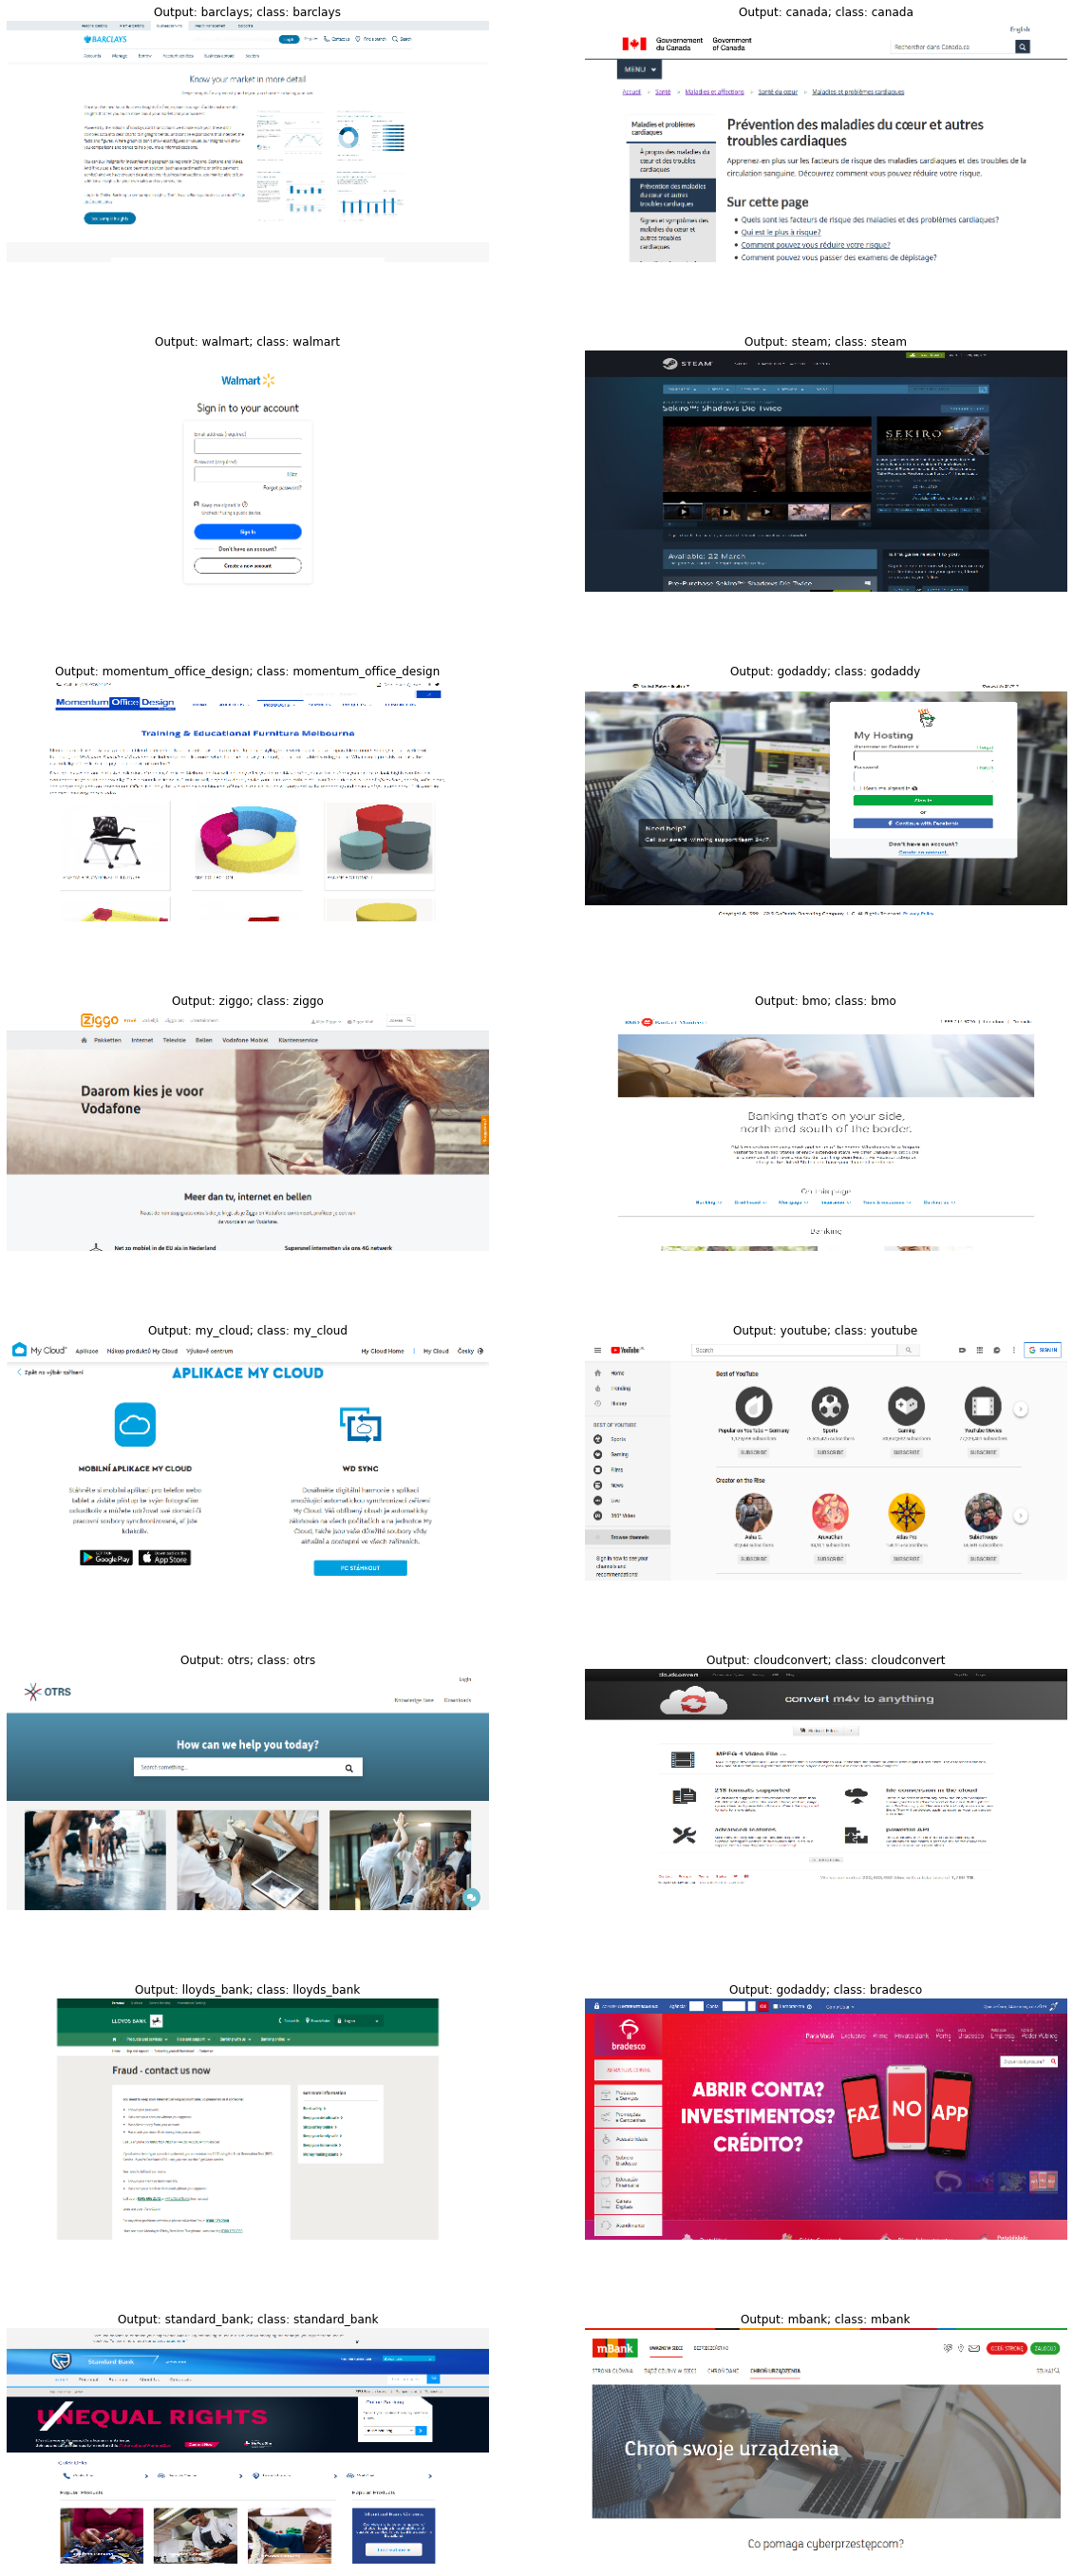

In [84]:
plt.figure(figsize=(20, 50))
probits = tf.nn.softmax(model.predict(imgs)).numpy()
for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(f"Output: {class_names[np.argmax(probits[i])]}; class: {class_names[int(class_labels[i])]}")
    plt.axis("off")

In [85]:
test_results = model.evaluate(test_ds, batch_size=32)
print("test loss, test accuracy, test pricision, test recall, test F1 score")
print(test_results[:-1] + [test_results[-1].mean()])

26/26 [==============================] - 5s 129ms/step - loss: 109.0054 - accuracy: 0.9447 - precision_5: 0.9447 - recall_4: 0.9447 - f1_score: 0.8011
test loss, test accuracy, test pricision, test recall, test F1 score
[109.00542449951172, 0.9447115659713745, 0.9447115659713745, 0.9447115659713745, 0.8010822]
